# (2) Sensor notebook

This notebook is supposed to show how my sensor implementation works.

My Sensor class derives from the Python class `threading.Thread`. As arguments, it takes:
* an instance of the athlete class presented in the athlete notebook,
* a queue to which the results from the athlete object are added (I use the thread-save implementation from `Queue.Queue`),
* a sensor ID,
* a rate in Hz at which the athlete is querried (default 20 Hz),
* the standard deviation of the white noise which is added to the athlete results (in meters, default 0.3).

The results in the queue are `MeasurementSpec` instances. MeasurementSpec is a `namedtuple` and contains the sensor ID (`ID`), the noisy coordinates (`coords`), and the time of the measurement (`time`).

## Imports

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
import numpy as np

In [5]:
from time import sleep

In [6]:
from streamanalysis import Athlete, Sensor

In [7]:
from Queue import Queue

## Data generation

I first create an `Athlete` instance, define the ID of the sensor, and initialize an empty queue. I again choose to set the `keepdata` flag to `True` in order to keep the created data in a list at `athlete.data`. Each data point is an `AthleteSpec` instance, i.e. a named tuple containing speed and velocity of the athlete.

In [8]:
athlete = Athlete(keepdata=True, seed = 1)
ID = '0'
q = Queue()

I then start the sensor which goes ahead and queries `athlete`. The result is a `MeasurementSpec` instance, i.e. a named tuple containing the sensor ID (`ID`), the measured coordinates (`coords`), and a time stamp (`time`). Each `MeasurementSpec` instance is added to the queue. After 5 minutes, I stop the sensor.

In [9]:
athlete.reset()
sensor = Sensor(athlete = athlete, queue = q, ID = ID, verbose = True)
sensor.start()
# Run the thread for 5 minutes
runtime = 60 * 5
sleep(runtime)
sensor.stop()

Sensor 0 started
Sensor 0 stopped


## Data analysis

I can now extract the measurements from the queue. I simply add all the `MeasurementSpec` instances on the queue to a list.

In [10]:
# Get measured data from queue
measurements = []
while not q.empty():
    measurements.append(q.get_nowait())

In [11]:
# Compare number of measurements to ellapsed time 
nmeas = len(measurements)
print 'Number of measurements', nmeas
print 'Number of measurements expected from runtime', runtime * 20

Number of measurements 6000
Number of measurements expected from runtime 6000


In [12]:
# Print first data element
print measurements[0].ID
print measurements[0].coords
print measurements[0].time

0
[ 49.8249477   50.06368185]
2016-07-13 11:17:46.654066


As expected, the initial element is close to the initial position at (50, 50).

In [13]:
# Get timing information from measurements by looping through the measurement list
delta_time = []
for i in range(nmeas-1):
    dt = measurements[i+1].time-measurements[i].time
    delta_time.append(dt.total_seconds())
# Calculate the ellapsed time by performing a cumulative sum over the time-deltas. I add 
# a zero to the beginning of the array to make it the same size as the measurement list.
ellapsed = np.append(0,np.cumsum(delta_time))/60.

I can now have a look at the precision of the timing by the sensor.

In [14]:
# Precision of timing in data collection
print 'Mean time-spacing:', np.mean(delta_time)
print 'Error on time-spacing:', np.std(delta_time)
print 'Total ellapsed time:', ellapsed[-1]

Mean time-spacing: 0.0500003778963
Error on time-spacing: 0.00156258645877
Total ellapsed time: 4.99920445


The timing of the sensor is very close to 0.05 seconds I expect from the 20 Hz frequency.

I can also recover the true data from the `athlete` instance.

In [15]:
# Get true data from athlete as an array (more convenient for plotting)
data = np.asarray(athlete.data)

Finally, I can compare the measured and input positions.

In [16]:
# Get measured and true positions (again as numpy arrays)
obs_coords = np.asarray([m.coords for m in measurements])
true_pos = data[:,0]

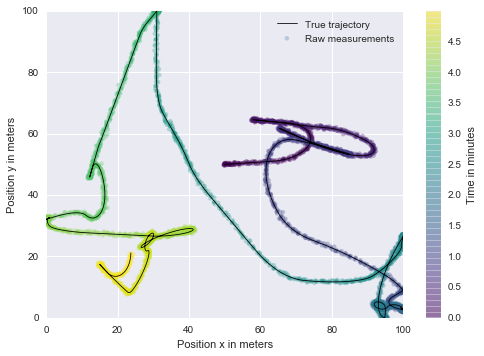

In [17]:
plt.scatter(obs_coords[:,0], obs_coords[:,1], c = ellapsed, alpha = .3, cmap = 'viridis',
            edgecolors='none', label = 'Raw measurements')
plt.plot(true_pos[:,0],true_pos[:,1], color = 'k', label = 'True trajectory', lw = .8)
plt.legend(loc = 0)
plt.xlim(0,100)
plt.xlabel('Position x in meters')
plt.ylim(0,100)
plt.ylabel('Position y in meters')
_=plt.colorbar(label = 'Time in minutes')

This plot shows a comparison of the true positions (black) and the measured coordinates over 5 minutes, color coded by the ellapsed time. As expected, the measured coordinates are a noisy version of the true trajectory. The error is also consistent with our expectations (0.3 meters):

In [18]:
# Error should be 0.3 meters
print (obs_coords - true_pos).std()

0.302124980863
